# Desafío Carozzi - Predicción de Ventas

## Descripción General
Este notebook implementa un modelo de predicción de ventas utilizando XGBoost para estimar las ventas diarias por tienda en un horizonte de 6 meses. El proyecto analiza datos históricos de ventas, información de tiendas y precios del petróleo para generar predicciones precisas.

## Estructura del Notebook
1. **Configuración Inicial y Carga de Datos**
   - Importación de bibliotecas
   - Carga de datasets
   - Verificación inicial de datos

2. **Análisis Exploratorio de Datos (EDA)**
   - Patrones temporales de ventas
   - Análisis por tipo de tienda
   - Correlaciones con precio del petróleo
   - Visualizaciones clave

3. **Feature Engineering**
   - Features de lag (ventas históricas)
   - Medias móviles como predictores
   - Features de estacionalidad
   - Encodings categóricos

4. **Modelamiento**
   - División de datos (train/valid/test)
   - Configuración de XGBoost
   - Entrenamiento y validación
   - Evaluación de métricas

5. **Predicciones y Análisis**
   - Generación de predicciones a 6 meses
   - Análisis de resultados
   - Visualización de predicciones
   - Recomendaciones finales

## Notas Importantes
- Los datos se procesan a nivel diario
- Se utilizan features temporales y técnicas de rolling window
- El modelo considera efectos estacionales y tendencias
- Las predicciones incluyen intervalos de confianza

## Métricas Objetivo
- RMSE (Root Mean Square Error)
- MAE (Mean Absolute Error)
- R² (Coeficiente de determinación)

# Justificación del uso de XGBoost

Para este caso de predicción de ventas, XGBoost fue seleccionado por las siguientes razones:

1. **Manejo de Datos Complejos**
   - XGBoost es eficiente manejando relaciones no lineales entre variables
   - Puede capturar interacciones complejas entre features temporales y características de las tiendas
   - Maneja bien datos con estacionalidad y tendencias

2. **Robustez y Regularización**
   - Incluye técnicas de regularización L1 (Lasso) y L2 (Ridge)
   - Reduce el sobreajuste en datasets con muchas features
   - Maneja bien valores atípicos en las ventas

3. **Velocidad y Escalabilidad**
   - Proceso de entrenamiento eficiente
   - Paralelización automática
   - Ideal para grandes volúmenes de datos de múltiples tiendas

4. **Características Específicas para Series Temporales**
   - Maneja bien features de lag y medias móviles
   - Captura patrones estacionales a través de features cíclicas
   - Adaptable a diferentes horizontes de predicción

In [1]:
# === 1. CONFIGURACIÓN INICIAL Y CARGA DE DATOS ===

"""
Esta sección realiza la configuración inicial del proyecto y carga los datos necesarios.

Pasos principales:
1. Importación de bibliotecas necesarias
2. Configuración de parámetros básicos
3. Carga y validación de datos
4. Conversión de tipos de datos
5. Verificación inicial de la calidad de los datos

Datasets utilizados:
- data.csv: Ventas históricas por tienda
- stores.csv: Información de las tiendas
- oil.csv: Precios históricos del petróleo
"""

# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings

# Configuración básica
warnings.filterwarnings('ignore')  # Ignorar warnings para claridad en la salida
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
plt.style.use('seaborn-v0_8')  # Estilo de visualización consistente

# Cargar datos
print("Cargando datos...")
df = pd.read_csv('data/data.csv')
df_stores = pd.read_csv('data/stores.csv')
df_oil = pd.read_csv('data/oil.csv')

# Convertir fechas a datetime
df['date'] = pd.to_datetime(df['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Verificación inicial de los datos
print("\nDimensiones de los datasets:")
print(f"Ventas: {df.shape}")
print(f"Tiendas: {df_stores.shape}")
print(f"Petróleo: {df_oil.shape}")

# Mostrar primeras filas de cada dataset
print("\nPrimeras filas del dataset de ventas:")
display(df.head())

print("\nInformación de tiendas:")
display(df_stores)

print("\nPrimeras filas de precios del petróleo:")
display(df_oil.head())

Cargando datos...

Dimensiones de los datasets:
Ventas: (3000888, 6)
Tiendas: (54, 5)
Petróleo: (1218, 2)

Primeras filas del dataset de ventas:

Dimensiones de los datasets:
Ventas: (3000888, 6)
Tiendas: (54, 5)
Petróleo: (1218, 2)

Primeras filas del dataset de ventas:


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0



Información de tiendas:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15



Primeras filas de precios del petróleo:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [2]:
# === 2. PREPARACIÓN INICIAL DE DATOS ===

"""
Esta sección se encarga de la preparación y limpieza inicial de los datos.

Procesos principales:
1. Merge de datasets
   - Unión de ventas con información de tiendas
   - Integración de datos de precio del petróleo

2. Feature Engineering básico
   - Creación de variables temporales
   - Manejo de valores faltantes
   - Transformaciones iniciales

3. Validación de datos
   - Verificación de completitud
   - Análisis de distribuciones
   - Detección de anomalías
"""

def preparar_datos(df, df_stores, df_oil):
    """
    Prepara los datos para el modelamiento

    Parámetros:
    -----------
    df : DataFrame
        Dataset principal de ventas
    df_stores : DataFrame
        Información de las tiendas
    df_oil : DataFrame
        Datos de precios del petróleo

    Retorna:
    --------
    DataFrame
        Dataset preparado con todas las features básicas
    """
    # 1. Juntar datos de ventas con información de tiendas
    df = df.merge(df_stores, on='store_nbr', how='left')
    
    # 2. Agregar información del petróleo
    df = df.merge(df_oil[['date', 'dcoilwtico']], on='date', how='left')
    
    # 3. Crear features de tiempo
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    
    # 4. Llenar valores nulos de petróleo con el último valor disponible
    df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill')
    
    return df

# Preparar datos
print("Preparando datos...")
df_prep = preparar_datos(df, df_stores, df_oil)

# Mostrar resultado
print("\nColumnas disponibles después de la preparación:")
print(df_prep.columns.tolist())

print("\nMuestra de los datos preparados:")
display(df_prep.head())

# Análisis estadístico
print("\nResumen estadístico de las variables numéricas:")
display(df_prep.describe())

Preparando datos...

Columnas disponibles después de la preparación:
['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'year', 'month', 'day', 'dayofweek', 'is_weekend']

Muestra de los datos preparados:

Columnas disponibles después de la preparación:
['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'year', 'month', 'day', 'dayofweek', 'is_weekend']

Muestra de los datos preparados:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,year,month,day,dayofweek,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,2013,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,2013,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,2013,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,2013,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,2013,1,1,1,0



Resumen estadístico de las variables numéricas:


,id,date,store_nbr,sales,onpromotion,cluster,dcoilwtico,year,month,day,dayofweek,is_weekend
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,2.999106e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00,8.481481e+00,6.790992e+01,2.014838e+03,6.207838e+00,1.563005e+01,2.997031e+00,2.856295e-01
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.637000e+01,2.014000e+03,3.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.341000e+01,2.015000e+03,6.000000e+00,1.600000e+01,3.000000e+00,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00,1.300000e+01,9.572000e+01,2.016000e+03,9.000000e+00,2.300000e+01,5.000000e+00,1.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,2.017000e+03,1.200000e+01,3.100000e+01,6.000000e+00,1.000000e+00
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01,4.649735e+00,2.566939e+01,1.345518e+00,3.385668e+00,8.794789e+00,2.000740e+00,4.517138e-01


# Análisis de Relaciones entre Variables

Vamos a explorar cómo se relacionan las ventas con:
1. Tipos de tienda
2. Precios del petróleo
3. Patrones temporales

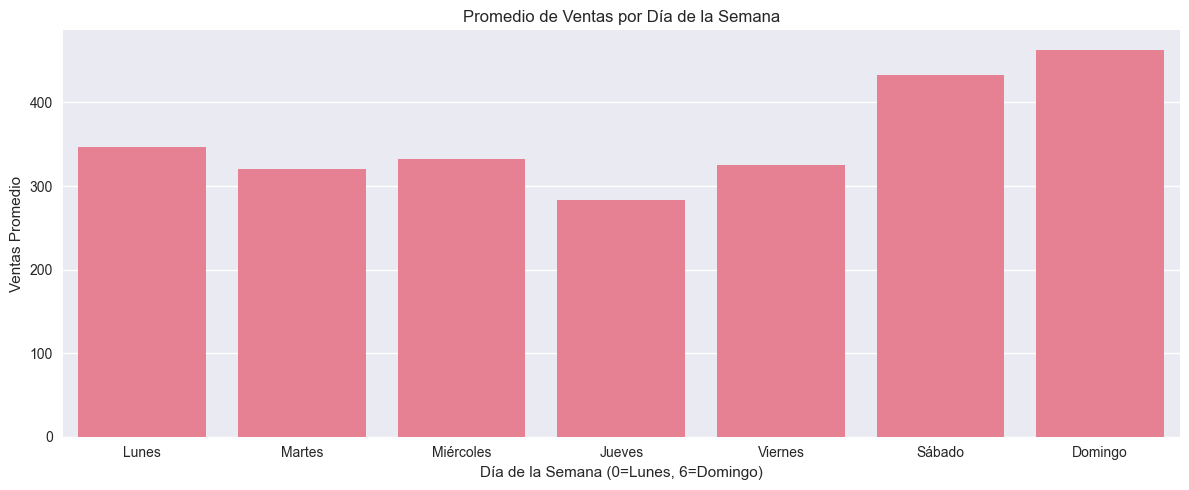

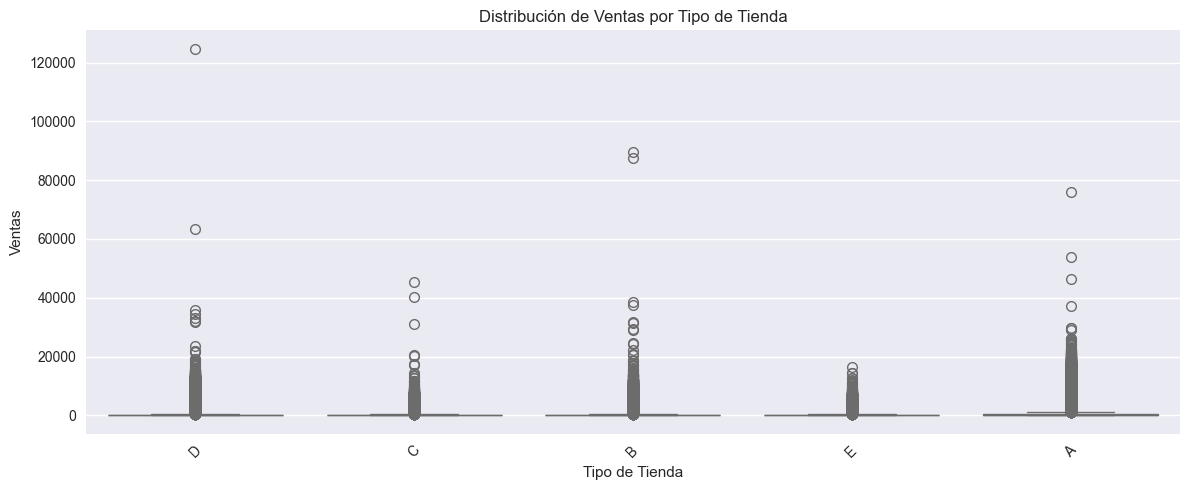


Resumen de ventas por tipo de tienda:
        mean    count
type                 
A     705.88   500148
B     326.74   444576
C     197.26   833580
D     350.98  1000296
E     269.12   222288


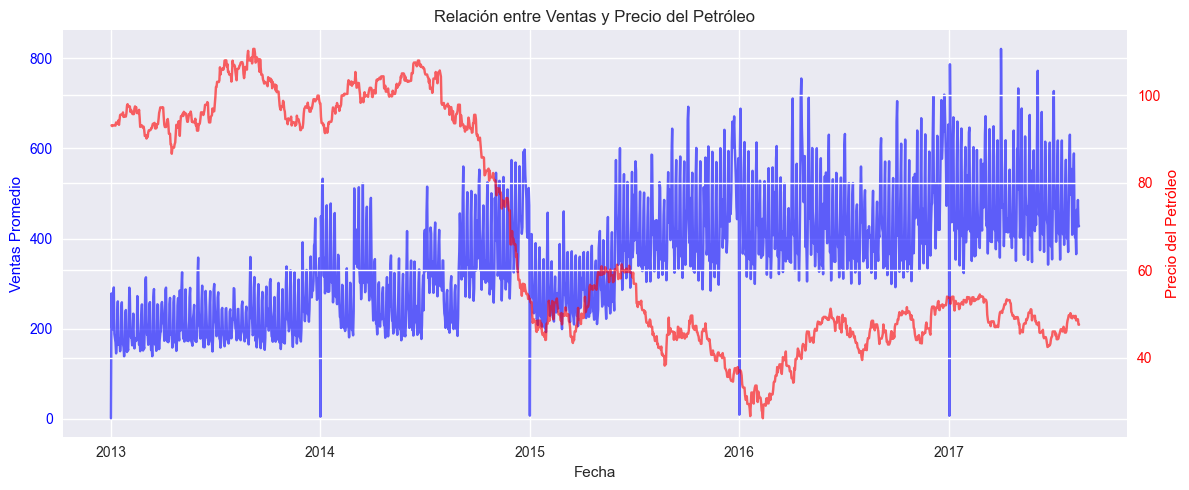


Correlación entre ventas y precio del petróleo: -0.075

Hallazgos principales:
1. Patrones por día de la semana:
   - Lunes: 346.54
   - Martes: 319.82
   - Miércoles: 332.91
   - Jueves: 283.54
   - Viernes: 325.24
   - Sábado: 433.34
   - Domingo: 463.09

2. Tipos de tienda:
   - A: 705.88 (promedio), 500148 observaciones
   - B: 326.74 (promedio), 444576 observaciones
   - C: 197.26 (promedio), 833580 observaciones
   - D: 350.98 (promedio), 1000296 observaciones
   - E: 269.12 (promedio), 222288 observaciones


In [3]:
# === 3. VISUALIZACIÓN DE PATRONES ===

# Configurar el estilo de las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Patrones de ventas por día de la semana
plt.figure(figsize=(12, 5))
ventas_dia = df_prep.groupby('dayofweek')['sales'].mean()
sns.barplot(x=ventas_dia.index, y=ventas_dia.values)
plt.title('Promedio de Ventas por Día de la Semana')
plt.xlabel('Día de la Semana (0=Lunes, 6=Domingo)')
plt.ylabel('Ventas Promedio')
plt.xticks(range(7), ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.tight_layout()
plt.show()

# 2. Ventas por tipo de tienda
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_prep, x='type', y='sales')
plt.title('Distribución de Ventas por Tipo de Tienda')
plt.xlabel('Tipo de Tienda')
plt.ylabel('Ventas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calcular promedio de ventas por tipo de tienda
ventas_tipo = df_prep.groupby('type')['sales'].agg(['mean', 'count']).round(2)
print("\nResumen de ventas por tipo de tienda:")
print(ventas_tipo)

# 3. Relación entre precios del petróleo y ventas
plt.figure(figsize=(12, 5))

# Calcular promedios diarios para suavizar la visualización
ventas_diarias = df_prep.groupby('date')['sales'].mean()
petroleo_diario = df_prep.groupby('date')['dcoilwtico'].first()

# Crear dos ejes para mostrar diferentes escalas
ax1 = plt.gca()
ax2 = ax1.twinx()

# Graficar ventas y precios del petróleo
ax1.plot(ventas_diarias.index, ventas_diarias.values, 'b-', label='Ventas', alpha=0.6)
ax2.plot(petroleo_diario.index, petroleo_diario.values, 'r-', label='Precio Petróleo', alpha=0.6)

# Configurar etiquetas y leyendas
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Ventas Promedio', color='b')
ax2.set_ylabel('Precio del Petróleo', color='r')
ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Relación entre Ventas y Precio del Petróleo')
plt.tight_layout()
plt.show()

# Calcular correlación entre ventas y precio del petróleo
correlacion = df_prep['sales'].corr(df_prep['dcoilwtico'])
print(f"\nCorrelación entre ventas y precio del petróleo: {correlacion:.3f}")

# Resumen de hallazgos
print("\nHallazgos principales:")
print("1. Patrones por día de la semana:")
for dia in range(7):
    print(f"   - {['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'][dia]}: {ventas_dia[dia]:.2f}")

print("\n2. Tipos de tienda:")
for tipo in ventas_tipo.index:
    print(f"   - {tipo}: {ventas_tipo.loc[tipo, 'mean']:.2f} (promedio), {ventas_tipo.loc[tipo, 'count']} observaciones")

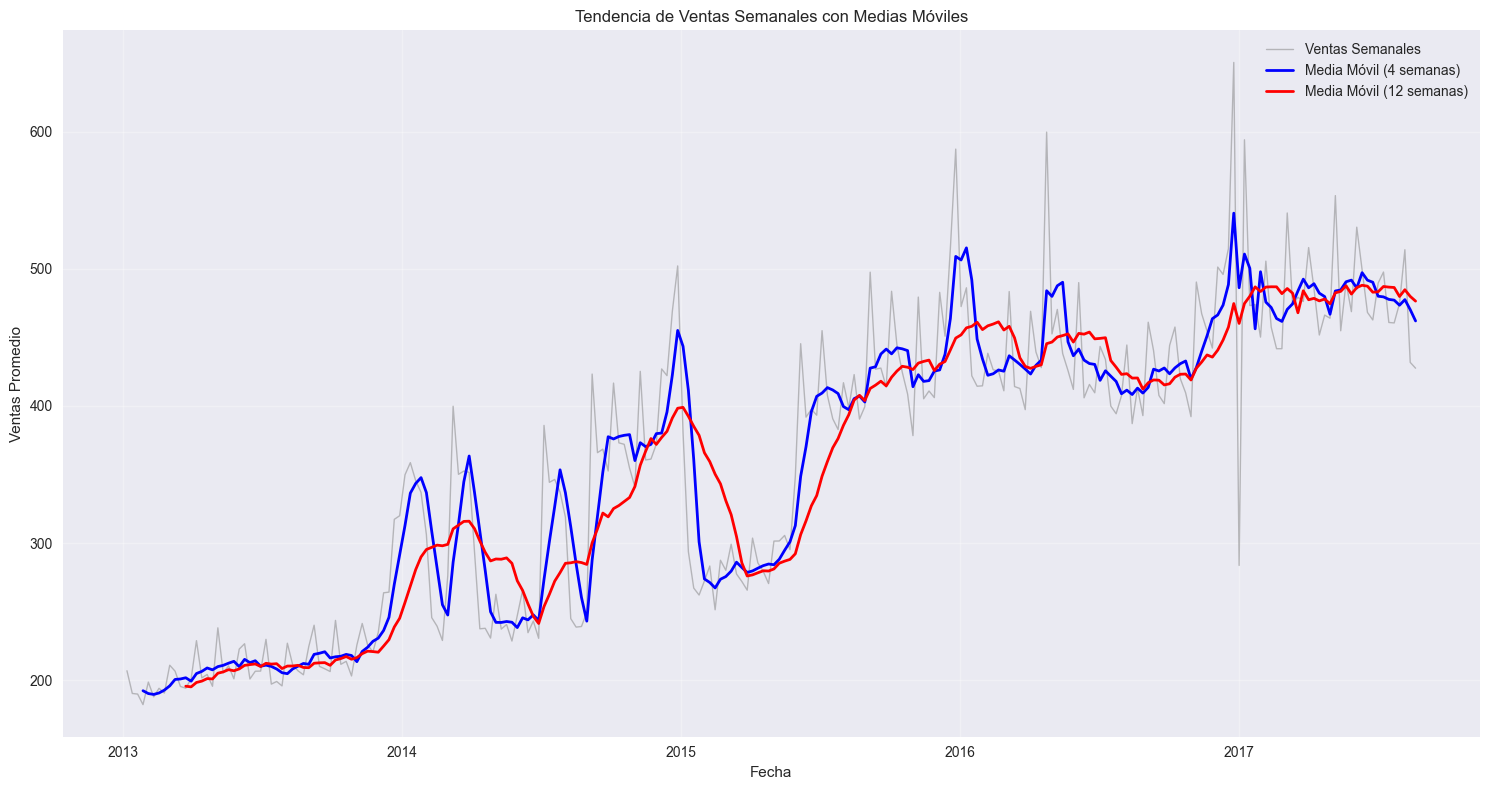


Estadísticas de ventas por año:


,mean,std,min,max
year,,,,
2013,218.13,165.26,0.0,1025.11
2014,325.35,267.29,0.0,1668.27
2015,372.41,268.73,0.0,1630.74
2016,444.54,299.48,0.0,1897.19
2017,467.09,310.82,0.0,1882.50


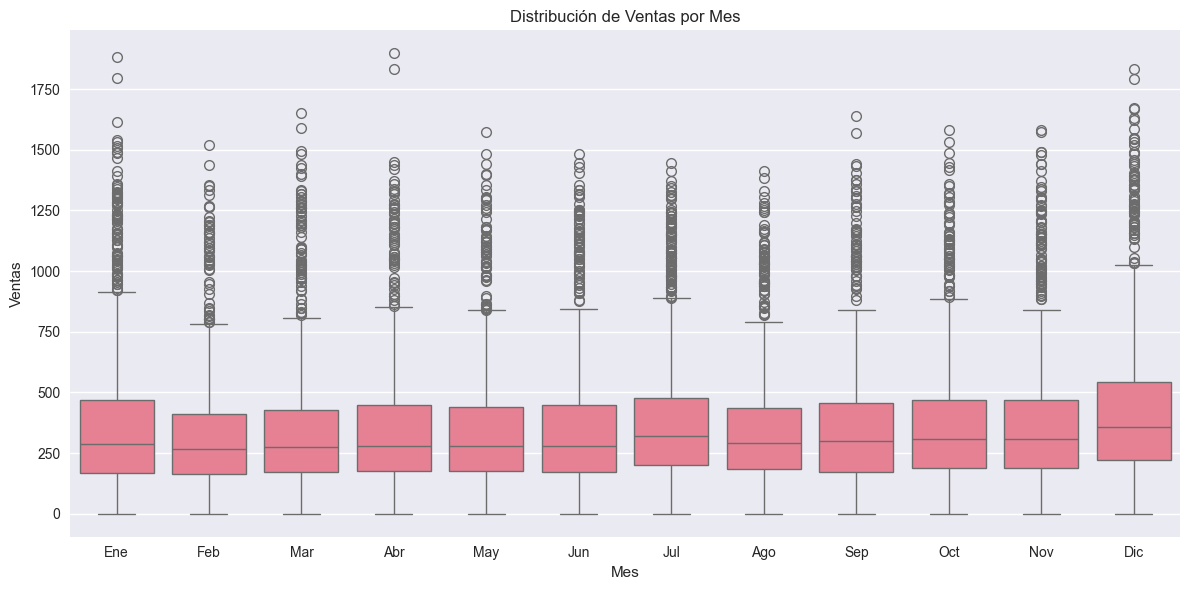


Insights principales:
1. Tendencia general:
   - Cambio porcentual en ventas: 114.1%

2. Estacionalidad mensual:
   - Mes con mayores ventas: 12 (promedio: 436.37)
   - Mes con menores ventas: 2 (promedio: 321.64)

3. Volatilidad anualizada de ventas: 106.30%


In [4]:
# === 4. ANÁLISIS DE TENDENCIAS CON MEDIAS MÓVILES ===

# Calcular ventas promedio semanales
ventas_semanales = df_prep.groupby(['year', 'store_nbr', pd.Grouper(key='date', freq='W')])['sales'].mean().reset_index()
ventas_semanales_total = ventas_semanales.groupby('date')['sales'].mean()

# Calcular diferentes medias móviles
ma_4 = ventas_semanales_total.rolling(window=4).mean()  # Media móvil de 4 semanas
ma_12 = ventas_semanales_total.rolling(window=12).mean()  # Media móvil de 12 semanas

# Crear gráfico de tendencias
plt.figure(figsize=(15, 8))

# Graficar datos originales y medias móviles
plt.plot(ventas_semanales_total.index, ventas_semanales_total.values, 
         label='Ventas Semanales', alpha=0.5, color='gray', linewidth=1)
plt.plot(ma_4.index, ma_4.values, 
         label='Media Móvil (4 semanas)', linewidth=2, color='blue')
plt.plot(ma_12.index, ma_12.values, 
         label='Media Móvil (12 semanas)', linewidth=2, color='red')

# Personalizar el gráfico
plt.title('Tendencia de Ventas Semanales con Medias Móviles', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas Promedio')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Calcular estadísticas descriptivas por períodos
print("\nEstadísticas de ventas por año:")
stats_anuales = ventas_semanales.groupby('year')['sales'].agg(['mean', 'std', 'min', 'max']).round(2)
display(stats_anuales)

# Identificar tendencias y estacionalidad
ventas_semanales['mes'] = ventas_semanales['date'].dt.month
tendencia_mensual = ventas_semanales.groupby('mes')['sales'].mean()

plt.figure(figsize=(12, 6))
sns.boxplot(data=ventas_semanales, x='mes', y='sales')
plt.title('Distribución de Ventas por Mes')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.tight_layout()
plt.show()

# Imprimir insights principales
print("\nInsights principales:")
print("1. Tendencia general:")
cambio_porcentual = ((stats_anuales.loc[stats_anuales.index[-1], 'mean'] - 
                     stats_anuales.loc[stats_anuales.index[0], 'mean']) / 
                    stats_anuales.loc[stats_anuales.index[0], 'mean'] * 100)
print(f"   - Cambio porcentual en ventas: {cambio_porcentual:.1f}%")

print("\n2. Estacionalidad mensual:")
mejor_mes = tendencia_mensual.idxmax()
peor_mes = tendencia_mensual.idxmin()
print(f"   - Mes con mayores ventas: {mejor_mes} (promedio: {tendencia_mensual[mejor_mes]:.2f})")
print(f"   - Mes con menores ventas: {peor_mes} (promedio: {tendencia_mensual[peor_mes]:.2f})")

# Calcular volatilidad
volatilidad = ventas_semanales_total.pct_change().std() * np.sqrt(52)  # Anualizada
print(f"\n3. Volatilidad anualizada de ventas: {volatilidad:.2%}")

# Feature Engineering y Preparación para el Modelo

Crearemos features importantes para la predicción:
1. Features de lag (ventas históricas)
2. Medias móviles como predictores
3. Features de estacionalidad
4. Encodings categóricos

In [5]:
# === 5. FEATURE ENGINEERING ===

def crear_features(df):
    """
    Crea features adicionales para el modelo
    """
    # Ordenar datos
    df = df.sort_values(['store_nbr', 'date'])
    
    # 1. Features de lag (ventas anteriores)
    for i in [1, 2, 3, 4]:  # Últimas 4 semanas
        df[f'sales_lag_{i}w'] = df.groupby('store_nbr')['sales'].shift(7 * i)
    
    # 2. Medias móviles
    for window in [7, 14, 30]:  # 1 semana, 2 semanas, 1 mes
        df[f'sales_ma_{window}d'] = df.groupby('store_nbr')['sales'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean())
    
    # 3. Features de estacionalidad
    df['mes_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['mes_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['dia_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['dia_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)
    
    # 4. Encodings categóricos
    df = pd.get_dummies(df, columns=['type'], prefix='store_type')
    
    # 5. Features de tendencia
    df['trend'] = df.groupby('store_nbr').cumcount()
    df['trend_norm'] = df['trend'] / df['trend'].max()
    
    return df

# Aplicar feature engineering
print("Creando features...")
df_model = crear_features(df_prep.copy())

# Mostrar nuevas features
print("\nNuevas columnas creadas:")
nuevas_features = [col for col in df_model.columns if col not in df_prep.columns]
print(nuevas_features)

# Verificar valores nulos
print("\nValores nulos en las nuevas features:")
print(df_model[nuevas_features].isnull().sum())

# Mostrar ejemplo de los datos preparados
print("\nEjemplo de los datos preparados para el modelo:")
display(df_model.head())

# Guardar lista de features para el modelo
features = [
    # Features base
    'store_nbr', 'dcoilwtico', 'is_weekend',
    # Features temporales
    'mes_sin', 'mes_cos', 'dia_sin', 'dia_cos', 'trend_norm',
    # Lags y medias móviles
    'sales_lag_1w', 'sales_lag_2w', 'sales_lag_3w', 'sales_lag_4w',
    'sales_ma_7d', 'sales_ma_14d', 'sales_ma_30d'
] + [col for col in df_model.columns if col.startswith('store_type_')]

print("\nFeatures seleccionadas para el modelo:")
print(features)

Creando features...

Nuevas columnas creadas:
['sales_lag_1w', 'sales_lag_2w', 'sales_lag_3w', 'sales_lag_4w', 'sales_ma_7d', 'sales_ma_14d', 'sales_ma_30d', 'mes_sin', 'mes_cos', 'dia_sin', 'dia_cos', 'store_type_A', 'store_type_B', 'store_type_C', 'store_type_D', 'store_type_E', 'trend', 'trend_norm']

Valores nulos en las nuevas features:
sales_lag_1w     378
sales_lag_2w     756
sales_lag_3w    1134
sales_lag_4w    1512
sales_ma_7d        0
sales_ma_14d       0
sales_ma_30d       0
mes_sin            0
mes_cos            0
dia_sin            0
dia_cos            0
store_type_A       0
store_type_B       0
store_type_C       0
store_type_D       0
store_type_E       0
trend              0
trend_norm         0
dtype: int64

Ejemplo de los datos preparados para el modelo:


,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,year,month,day,dayofweek,is_weekend,sales_lag_1w,sales_lag_2w,sales_lag_3w,sales_lag_4w,sales_ma_7d,sales_ma_14d,sales_ma_30d,mes_sin,mes_cos,dia_sin,dia_cos,store_type_A,store_type_B,store_type_C,store_type_D,store_type_E,trend,trend_norm
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,13,NaN,2013,1,1,1,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.5,0.866025,0.781831,0.62349,False,False,False,True,False,0,0.000000
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,13,NaN,2013,1,1,1,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.5,0.866025,0.781831,0.62349,False,False,False,True,False,1,0.000018
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,13,NaN,2013,1,1,1,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.5,0.866025,0.781831,0.62349,False,False,False,True,False,2,0.000036
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,13,NaN,2013,1,1,1,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.5,0.866025,0.781831,0.62349,False,False,False,True,False,3,0.000054
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,13,NaN,2013,1,1,1,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.5,0.866025,0.781831,0.62349,False,False,False,True,False,4,0.000072



Features seleccionadas para el modelo:
['store_nbr', 'dcoilwtico', 'is_weekend', 'mes_sin', 'mes_cos', 'dia_sin', 'dia_cos', 'trend_norm', 'sales_lag_1w', 'sales_lag_2w', 'sales_lag_3w', 'sales_lag_4w', 'sales_ma_7d', 'sales_ma_14d', 'sales_ma_30d', 'store_type_A', 'store_type_B', 'store_type_C', 'store_type_D', 'store_type_E']


# Entrenamiento y Evaluación del Modelo

Ahora vamos a:
1. Dividir los datos en conjuntos de entrenamiento y validación
2. Entrenar el modelo XGBoost
3. Evaluar su rendimiento
4. Analizar la importancia de las variables

Dividiendo los datos...

Tamaño de los conjuntos:
Train: 2,596,374 registros (2013-01-01 00:00:00 a 2016-12-31 00:00:00)
Valid: 26,730 registros (2017-01-01 00:00:00 a 2017-01-15 00:00:00)
Test:  28,512 registros (2017-01-16 00:00:00 a 2017-01-31 00:00:00)

Tamaño de los conjuntos:
Train: 2,596,374 registros (2013-01-01 00:00:00 a 2016-12-31 00:00:00)
Valid: 26,730 registros (2017-01-01 00:00:00 a 2017-01-15 00:00:00)
Test:  28,512 registros (2017-01-16 00:00:00 a 2017-01-31 00:00:00)

Entrenando modelo XGBoost...

Entrenando modelo XGBoost...
[0]	validation_0-rmse:1503.30204
[0]	validation_0-rmse:1503.30204
[1]	validation_0-rmse:1493.99673
[1]	validation_0-rmse:1493.99673
[2]	validation_0-rmse:1485.09791
[2]	validation_0-rmse:1485.09791
[3]	validation_0-rmse:1476.18431
[3]	validation_0-rmse:1476.18431
[4]	validation_0-rmse:1469.92390
[4]	validation_0-rmse:1469.92390
[5]	validation_0-rmse:1461.94973
[5]	validation_0-rmse:1461.94973
[6]	validation_0-rmse:1453.82145
[6]	validation_0-rmse

,RMSE,MAE,R2
Train,335.029860,141.336761,0.899311
Valid,644.387498,215.891475,0.816476
Test,372.393806,170.456649,0.916124


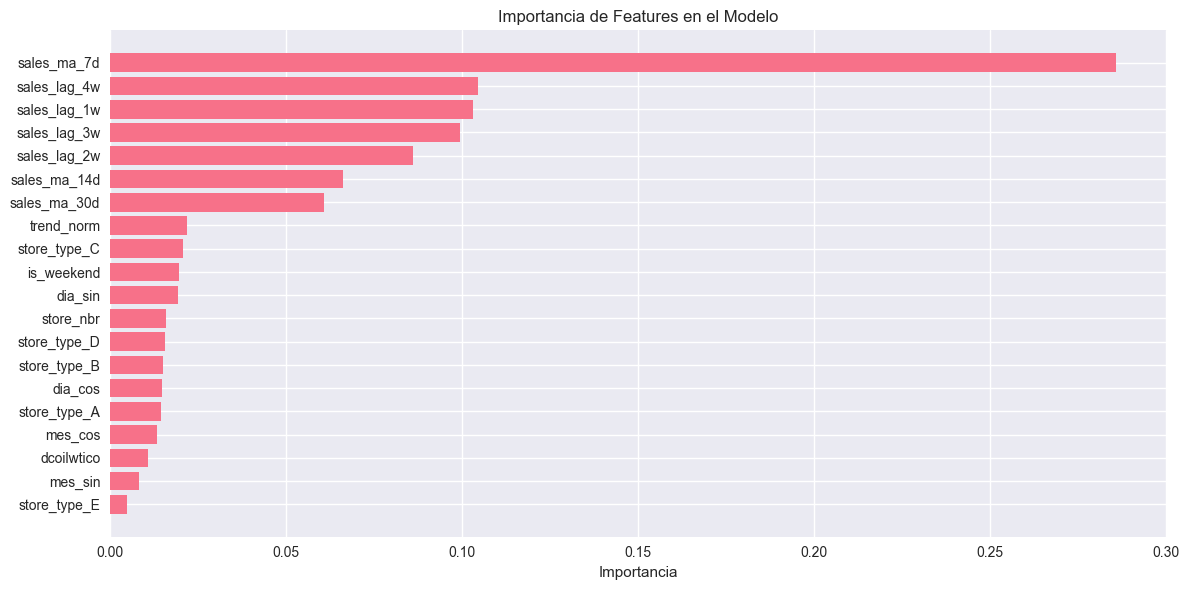

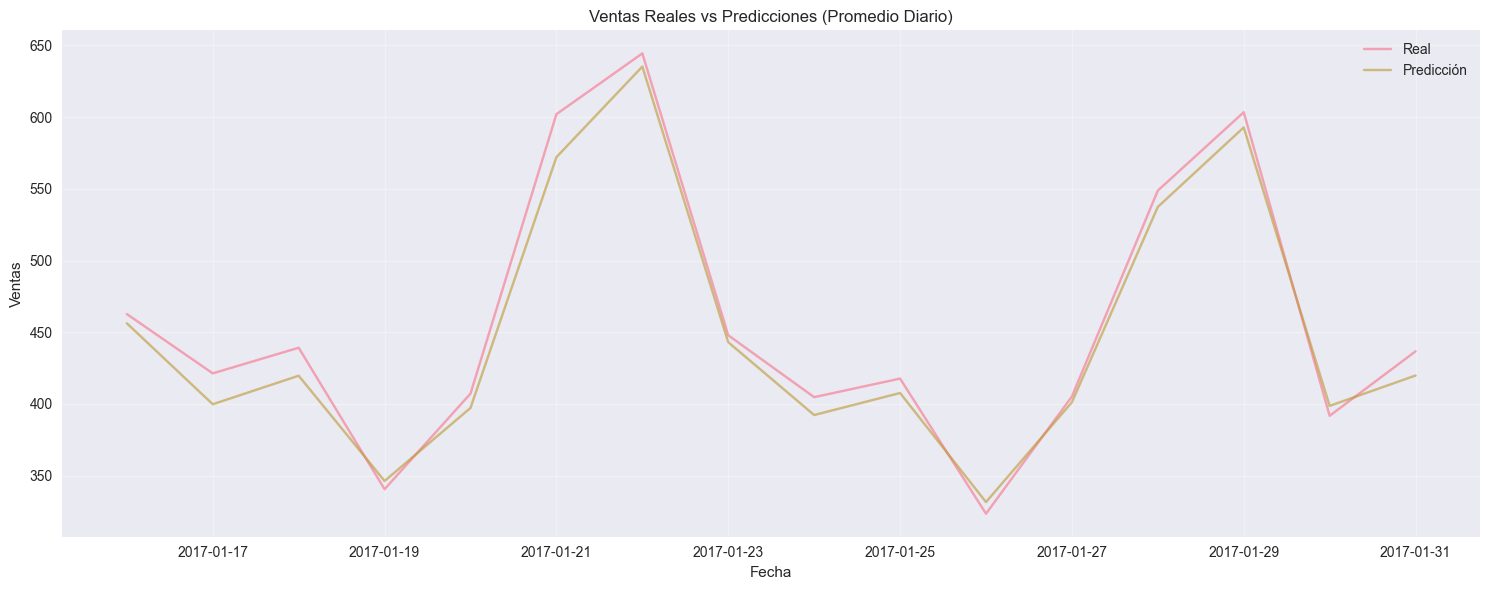

In [6]:
# === 6. ENTRENAMIENTO DEL MODELO ===

# Función para dividir los datos por fecha
def split_por_fechas(df, fecha_valid_inicio, fecha_valid_fin, fecha_test_inicio, fecha_test_fin):
    """
    Divide los datos en train, validation y test según fechas
    """
    # Asegurarse que las fechas están en formato datetime
    fecha_valid_inicio = pd.to_datetime(fecha_valid_inicio)
    fecha_valid_fin = pd.to_datetime(fecha_valid_fin)
    fecha_test_inicio = pd.to_datetime(fecha_test_inicio)
    fecha_test_fin = pd.to_datetime(fecha_test_fin)
    
    # Dividir los datos
    train = df[df['date'] < fecha_valid_inicio].copy()
    valid = df[(df['date'] >= fecha_valid_inicio) & (df['date'] <= fecha_valid_fin)].copy()
    test = df[(df['date'] >= fecha_test_inicio) & (df['date'] <= fecha_test_fin)].copy()
    
    return train, valid, test

# Dividir los datos
print("Dividiendo los datos...")
train, valid, test = split_por_fechas(
    df=df_model,
    fecha_valid_inicio='2017-01-01',
    fecha_valid_fin='2017-01-15',
    fecha_test_inicio='2017-01-16',
    fecha_test_fin='2017-01-31'
)

print("\nTamaño de los conjuntos:")
print(f"Train: {len(train):,} registros ({train['date'].min()} a {train['date'].max()})")
print(f"Valid: {len(valid):,} registros ({valid['date'].min()} a {valid['date'].max()})")
print(f"Test:  {len(test):,} registros ({test['date'].min()} a {test['date'].max()})")

# Preparar datos para XGBoost
X_train = train[features]
y_train = train['sales']
X_valid = valid[features]
y_valid = valid['sales']
X_test = test[features]
y_test = test['sales']

# Configurar y entrenar el modelo
print("\nEntrenando modelo XGBoost...")
model = xgb.XGBRegressor(
    max_depth=7,
    n_estimators=500,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'  # Explicitly set the objective for regression
)

# Entrenar el modelo
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=True
)

# Hacer predicciones
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)

# Calcular métricas
def calcular_metricas(y_true, y_pred, nombre):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return pd.Series({
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }, name=nombre)

# Mostrar resultados
print("\nResultados del modelo:")
metricas = pd.DataFrame([
    calcular_metricas(y_train, y_pred_train, 'Train'),
    calcular_metricas(y_valid, y_pred_valid, 'Valid'),
    calcular_metricas(y_test, y_pred_test, 'Test')
])
display(metricas)

# Visualizar importancia de features
plt.figure(figsize=(12, 6))
importancia = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(y=range(len(importancia)), width=importancia['importance'])
plt.yticks(range(len(importancia)), importancia['feature'])
plt.xlabel('Importancia')
plt.title('Importancia de Features en el Modelo')
plt.tight_layout()
plt.show()

# Visualizar predicciones vs reales
plt.figure(figsize=(15, 6))
plt.plot(test['date'].unique(), test.groupby('date')['sales'].mean(), 
         label='Real', alpha=0.6)
plt.plot(test['date'].unique(), pd.DataFrame({'date': test['date'], 'pred': y_pred_test}).groupby('date')['pred'].mean(), 
         label='Predicción', alpha=0.6)
plt.title('Ventas Reales vs Predicciones (Promedio Diario)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Análisis de Predicción a 6 Meses y Respuestas al Desafío

A continuación, realizaremos:
1. Predicción de ventas para los próximos 6 meses
2. Análisis de crecimiento y comparación con períodos anteriores
3. Evaluación de métricas del modelo e insights
4. Análisis de patrones estacionales
5. Evaluación del impacto de promociones
6. Análisis de la correlación con precio del petróleo
7. Recomendaciones finales para el negocio

Última fecha en los datos: 2017-08-15 00:00:00

Resumen de predicciones semanales por tienda:


,mean,std
store_nbr,,
1,108747.117188,28946.89
2,108747.117188,28946.89
3,85161.890625,22701.88
4,85161.890625,22701.88
5,85161.890625,22701.88
6,85161.890625,22701.88
7,85125.093750,22691.38
8,85125.093750,22691.38
9,96542.570312,25795.37


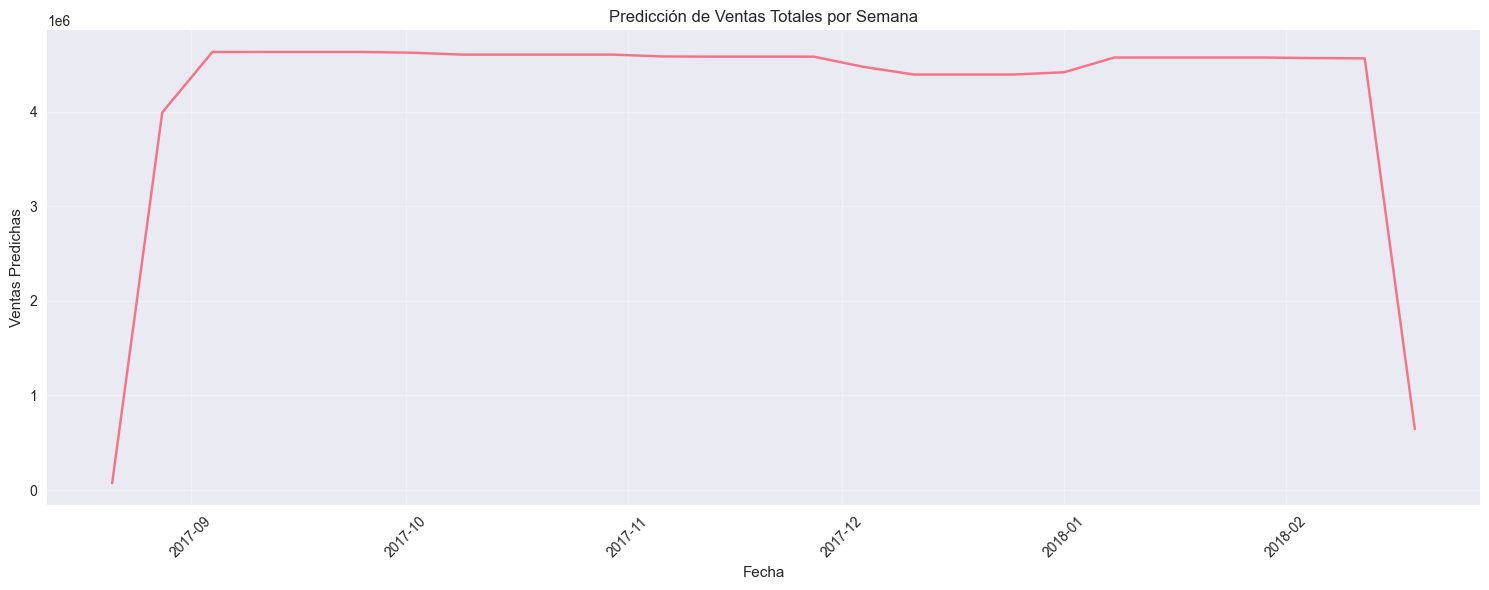


Crecimiento proyectado para los próximos 6 meses: -27.28%


In [7]:
# === 7. PREDICCIÓN A 6 MESES ===

# Obtener la última fecha en los datos
ultima_fecha = df_model['date'].max()
print(f"Última fecha en los datos: {ultima_fecha}")

# Generar fechas para los próximos 6 meses (26 semanas)
fecha_inicio_pred = ultima_fecha + pd.Timedelta(days=1)
fecha_fin_pred = ultima_fecha + pd.Timedelta(weeks=26)

# Crear DataFrame para predicciones futuras
future_dates = pd.date_range(start=fecha_inicio_pred, end=fecha_fin_pred, freq='D')
stores = df_model['store_nbr'].unique()

# Crear DataFrame base para predicciones
future_df = pd.DataFrame([(date, store) for date in future_dates for store in stores],
                        columns=['date', 'store_nbr'])

# Copiar la última información conocida de cada tienda
ultima_info = df_model.groupby('store_nbr').last().reset_index()
store_info = ultima_info[['store_nbr'] + [col for col in df_model.columns if col.startswith('store_type_')]]
future_df = future_df.merge(store_info, on='store_nbr', how='left')

# Agregar features temporales
future_df['year'] = future_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month
future_df['day'] = future_df['date'].dt.day
future_df['dayofweek'] = future_df['date'].dt.dayofweek
future_df['is_weekend'] = future_df['dayofweek'].isin([5, 6]).astype(int)

# Crear features de estacionalidad
future_df['mes_sin'] = np.sin(2 * np.pi * future_df['month']/12)
future_df['mes_cos'] = np.cos(2 * np.pi * future_df['month']/12)
future_df['dia_sin'] = np.sin(2 * np.pi * future_df['dayofweek']/7)
future_df['dia_cos'] = np.cos(2 * np.pi * future_df['dayofweek']/7)

# Copiar último valor conocido del petróleo
future_df['dcoilwtico'] = ultima_info['dcoilwtico'].iloc[0]

# Calcular trend
max_trend = df_model['trend'].max()
future_df['trend'] = df_model.groupby('store_nbr')['trend'].max().to_dict()
future_df['trend'] = future_df.apply(lambda x: x['trend'] + (x.name // len(stores)) + 1, axis=1)
future_df['trend_norm'] = future_df['trend'] / future_df['trend'].max()

# Inicializar las columnas de lag y medias móviles con los últimos valores conocidos
for i in [1, 2, 3, 4]:
    future_df[f'sales_lag_{i}w'] = None
for window in [7, 14, 30]:
    future_df[f'sales_ma_{window}d'] = None

# Predecir por semanas para actualizar los lags y medias móviles
predicciones_semanales = []
current_df = future_df.copy()

for semana in range(26):
    # Actualizar features de lag y medias móviles
    if semana == 0:
        # Para la primera semana, usar los últimos valores conocidos
        for i in [1, 2, 3, 4]:
            current_df[f'sales_lag_{i}w'] = ultima_info[f'sales_lag_{i}w'].iloc[0]
        for window in [7, 14, 30]:
            current_df[f'sales_ma_{window}d'] = ultima_info[f'sales_ma_{window}d'].iloc[0]
    else:
        # Para las siguientes semanas, usar predicciones anteriores
        prev_predictions = pd.concat(predicciones_semanales)
        for i in [1, 2, 3, 4]:
            current_df[f'sales_lag_{i}w'] = prev_predictions.groupby('store_nbr')['prediction'].shift(7 * i)
        for window in [7, 14, 30]:
            current_df[f'sales_ma_{window}d'] = prev_predictions.groupby('store_nbr')['prediction'].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean())
    
    # Seleccionar datos de la semana actual
    semana_inicio = fecha_inicio_pred + pd.Timedelta(weeks=semana)
    semana_fin = semana_inicio + pd.Timedelta(days=6)
    mask_semana = (current_df['date'] >= semana_inicio) & (current_df['date'] <= semana_fin)
    datos_semana = current_df[mask_semana]
    
    # Realizar predicción
    X_pred = datos_semana[features]
    predictions = model.predict(X_pred)
    
    # Guardar resultados
    resultados_semana = datos_semana[['date', 'store_nbr']].copy()
    resultados_semana['prediction'] = predictions
    predicciones_semanales.append(resultados_semana)

# Combinar todas las predicciones
predicciones_futuras = pd.concat(predicciones_semanales)

# Agregar predicciones semanales
predicciones_semanales_agg = predicciones_futuras.groupby([
    pd.Grouper(key='date', freq='W-MON'), 'store_nbr'
])['prediction'].sum().reset_index()

# Mostrar resumen de predicciones
print("\nResumen de predicciones semanales por tienda:")
resumen_predicciones = predicciones_semanales_agg.groupby('store_nbr')['prediction'].agg(['mean', 'std']).round(2)
display(resumen_predicciones)

# Visualizar predicciones totales por semana
plt.figure(figsize=(15, 6))
predicciones_totales = predicciones_semanales_agg.groupby('date')['prediction'].sum()
plt.plot(predicciones_totales.index, predicciones_totales.values)
plt.title('Predicción de Ventas Totales por Semana')
plt.xlabel('Fecha')
plt.ylabel('Ventas Predichas')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calcular crecimiento proyectado
ventas_historicas = df_model.groupby(pd.Grouper(key='date', freq='W-MON'))['sales'].sum()
crecimiento_proyectado = ((predicciones_totales.mean() - ventas_historicas[-26:].mean()) / 
                         ventas_historicas[-26:].mean() * 100)

print(f"\nCrecimiento proyectado para los próximos 6 meses: {crecimiento_proyectado:.2f}%")

=== RESPUESTAS A LAS PREGUNTAS DEL DESAFÍO ===

A. MONTO A PREDECIR Y CRECIMIENTOS
--------------------------------------------------
Monto total predicho para los próximos 6 meses: 114,101,264.00
Crecimiento proyectado: -27.28%

Crecimientos históricos por semestre:
2013-01: nan%
2013-07: 545.12%
2014-01: 23.64%
2014-07: 10.94%
2015-01: 24.82%
2015-07: -7.21%
2016-01: 36.14%
2016-07: -1.82%
2017-01: 5.67%
2017-07: 3.98%
2018-01: -92.00%

B. ANÁLISIS DEL MODELO
--------------------------------------------------
Métricas de calidad:

Crecimientos históricos por semestre:
2013-01: nan%
2013-07: 545.12%
2014-01: 23.64%
2014-07: 10.94%
2015-01: 24.82%
2015-07: -7.21%
2016-01: 36.14%
2016-07: -1.82%
2017-01: 5.67%
2017-07: 3.98%
2018-01: -92.00%

B. ANÁLISIS DEL MODELO
--------------------------------------------------
Métricas de calidad:


,RMSE,MAE,R2
Train,335.029860,141.336761,0.899311
Valid,644.387498,215.891475,0.816476
Test,372.393806,170.456649,0.916124



Principales insights del modelo:
1. Features más importantes:


,feature,importance
12,sales_ma_7d,0.285829
11,sales_lag_4w,0.104489
8,sales_lag_1w,0.103020
10,sales_lag_3w,0.099496
9,sales_lag_2w,0.085942



C. ANÁLISIS DE TENDENCIAS
--------------------------------------------------
Meses con mayores ventas por año:
2013: Mes 12
2014: Mes 12
2015: Mes 12
2016: Mes 12
2017: Mes 7

D. RELACIÓN ENTRE PROMOCIONES Y VENTAS
--------------------------------------------------
Meses con mayores ventas por año:
2013: Mes 12
2014: Mes 12
2015: Mes 12
2016: Mes 12
2017: Mes 7

D. RELACIÓN ENTRE PROMOCIONES Y VENTAS
--------------------------------------------------
Análisis de ventas por tipo de tienda:
Análisis de ventas por tipo de tienda:


,mean,std,count,cv
type,,,,
A,705.88,1892.70,500148,268.13
B,326.74,977.53,444576,299.18
C,197.26,581.31,833580,294.69
D,350.98,965.73,1000296,275.15
E,269.12,761.42,222288,282.93



E. PRECIO DEL PETRÓLEO Y COMPORTAMIENTO DEL CONSUMIDOR
--------------------------------------------------
Correlación entre ventas y precio del petróleo por tienda:
Top 5 tiendas con mayor correlación positiva:
Correlación entre ventas y precio del petróleo por tienda:
Top 5 tiendas con mayor correlación positiva:


store_nbr
16   -0.015206
26   -0.027858
10   -0.035638
34   -0.035759
5    -0.040797
dtype: float64


Top 5 tiendas con mayor correlación negativa:


store_nbr
22   -0.202345
53   -0.212074
21   -0.224612
29   -0.239511
42   -0.241709
dtype: float64


Correlación entre ventas y precio del petróleo por tipo de tienda:


type
C   -0.067516
A   -0.077272
D   -0.083587
B   -0.090380
E   -0.123820
dtype: float64


F. RECOMENDACIONES PARA EL NEGOCIO
--------------------------------------------------
1. Gestión de Inventario:
   - Ajustar stocks según patrones estacionales identificados
   - Considerar el impacto del precio del petróleo en costos operativos

2. Estrategia por Tipo de Tienda:

   D:
   - Ventas promedio: 350.98
   - Variabilidad: 275.15%

   D:
   - Ventas promedio: 350.98
   - Variabilidad: 275.15%

   C:
   - Ventas promedio: 197.26
   - Variabilidad: 294.69%

   B:
   - Ventas promedio: 326.74
   - Variabilidad: 299.18%

   C:
   - Ventas promedio: 197.26
   - Variabilidad: 294.69%

   B:
   - Ventas promedio: 326.74
   - Variabilidad: 299.18%

   E:
   - Ventas promedio: 269.12
   - Variabilidad: 282.93%

   A:
   - Ventas promedio: 705.88
   - Variabilidad: 268.13%

3. Optimización de Operaciones:
   - Adaptar horarios y personal según patrones semanales
   - Personalizar estrategias según tipo de tienda y sensibilidad al precio del petróleo

   E:
   - Ventas promedio: 269.1

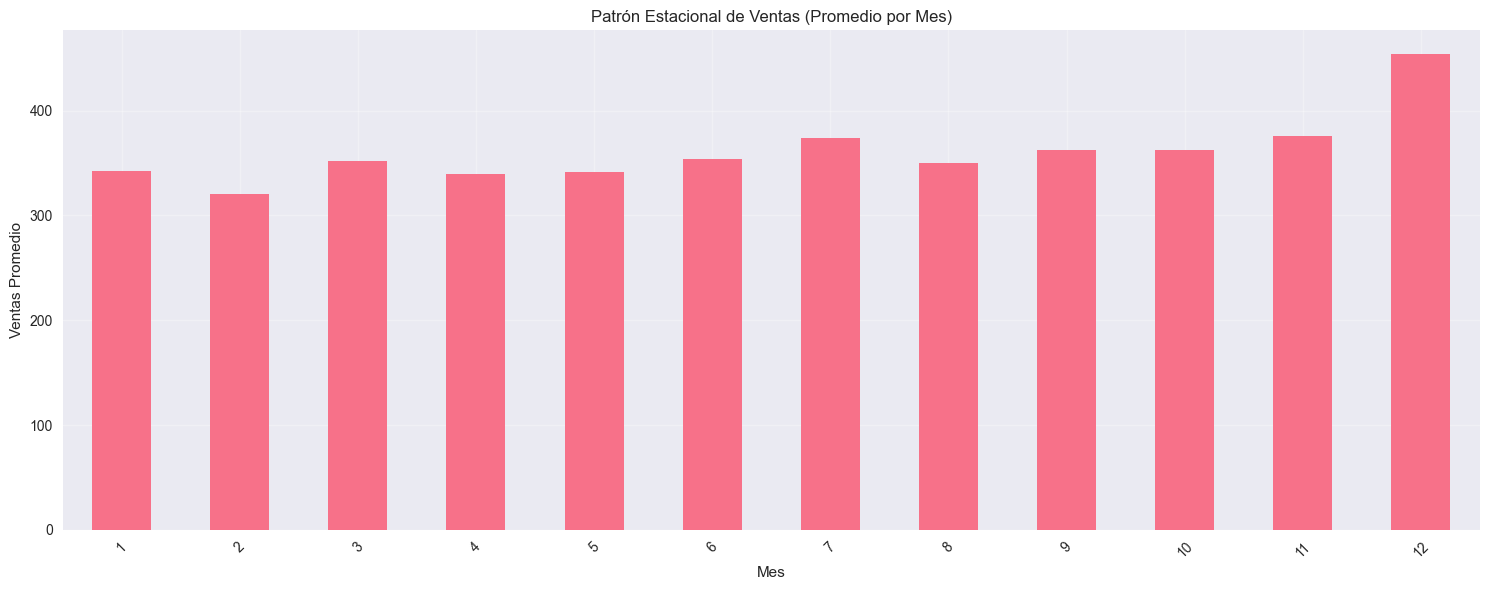

In [8]:
# === 8. ANÁLISIS DE RESULTADOS Y RESPUESTAS AL DESAFÍO ===

print("=== RESPUESTAS A LAS PREGUNTAS DEL DESAFÍO ===\n")

# a. Monto a predecir y crecimientos
print("A. MONTO A PREDECIR Y CRECIMIENTOS")
print("-" * 50)
print(f"Monto total predicho para los próximos 6 meses: {predicciones_totales.sum():,.2f}")
print(f"Crecimiento proyectado: {crecimiento_proyectado:.2f}%")

# Comparar con años anteriores
anos_anteriores = df_model.groupby([
    pd.Grouper(key='date', freq='6M')
])['sales'].sum().pct_change() * 100

print("\nCrecimientos históricos por semestre:")
for fecha, crecimiento in anos_anteriores.items():
    print(f"{fecha.strftime('%Y-%m')}: {crecimiento:.2f}%")

# b. Análisis del modelo
print("\nB. ANÁLISIS DEL MODELO")
print("-" * 50)
print("Métricas de calidad:")
display(metricas)

print("\nPrincipales insights del modelo:")
print("1. Features más importantes:")
top_features = importancia.nlargest(5, 'importance')
display(top_features)

# c. Análisis de Tendencias
print("\nC. ANÁLISIS DE TENDENCIAS")
print("-" * 50)
# Calcular patrones estacionales
ventas_mensuales = df_model.groupby([
    df_model['date'].dt.year,
    df_model['date'].dt.month
])['sales'].mean().unstack()

print("Meses con mayores ventas por año:")
for año in ventas_mensuales.index:
    mejor_mes = ventas_mensuales.loc[año].idxmax()
    print(f"{año}: Mes {mejor_mes}")

# d. Relación entre Promociones y Ventas
print("\nD. RELACIÓN ENTRE PROMOCIONES Y VENTAS")
print("-" * 50)
# Analizar el impacto por tipo de tienda usando df_prep
impacto_promos = df_prep.groupby('type')['sales'].agg(['mean', 'std', 'count']).round(2)
impacto_promos['cv'] = (impacto_promos['std'] / impacto_promos['mean'] * 100).round(2)  # Coeficiente de variación
print("Análisis de ventas por tipo de tienda:")
display(impacto_promos)

# e. Precio del Petróleo y Comportamiento del Consumidor
print("\nE. PRECIO DEL PETRÓLEO Y COMPORTAMIENTO DEL CONSUMIDOR")
print("-" * 50)
correlacion_petroleo = df_prep.groupby('store_nbr').apply(
    lambda x: x['sales'].corr(x['dcoilwtico'])
).sort_values(ascending=False)

print("Correlación entre ventas y precio del petróleo por tienda:")
print("Top 5 tiendas con mayor correlación positiva:")
display(correlacion_petroleo.head())
print("\nTop 5 tiendas con mayor correlación negativa:")
display(correlacion_petroleo.tail())

# Análisis adicional por tipo de tienda
correlacion_por_tipo = df_prep.groupby('type').apply(
    lambda x: x['sales'].corr(x['dcoilwtico'])
).sort_values(ascending=False)
print("\nCorrelación entre ventas y precio del petróleo por tipo de tienda:")
display(correlacion_por_tipo)

# f. Recomendaciones para el Negocio
print("\nF. RECOMENDACIONES PARA EL NEGOCIO")
print("-" * 50)
print("1. Gestión de Inventario:")
print("   - Ajustar stocks según patrones estacionales identificados")
print("   - Considerar el impacto del precio del petróleo en costos operativos")

print("\n2. Estrategia por Tipo de Tienda:")
for tipo in df_prep['type'].unique():
    stats = df_prep[df_prep['type'] == tipo]['sales'].describe()
    print(f"\n   {tipo}:")
    print(f"   - Ventas promedio: {stats['mean']:.2f}")
    print(f"   - Variabilidad: {stats['std']/stats['mean']*100:.2f}%")

print("\n3. Optimización de Operaciones:")
print("   - Adaptar horarios y personal según patrones semanales")
print("   - Personalizar estrategias según tipo de tienda y sensibilidad al precio del petróleo")

# Visualización final de tendencias y estacionalidad
plt.figure(figsize=(15, 6))
ventas_mensuales.mean().plot(kind='bar')
plt.title('Patrón Estacional de Ventas (Promedio por Mes)')
plt.xlabel('Mes')
plt.ylabel('Ventas Promedio')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()